# Построение деревьев решений

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

 ## Загрузка данных (задача классификации).


In [2]:
train_data_titanic = pd.read_csv('train3.csv')
test_data_titanic = pd.read_csv('test3.csv')

print(train_data_titanic.head())

test_ids_titanic = test_data_titanic['PassengerId'].reset_index(drop=True)

train_data_titanic = train_data_titanic.drop(['PassengerId'], axis=1)
test_data_titanic = test_data_titanic.drop(['PassengerId'], axis=1)

   PassengerId  Survived  Pclass  \
0          486         0       3   
1          426         0       3   
2          780         1       1   
3          248         1       2   
4          184         1       2   

                                                Name     Sex   Age  SibSp  \
0                             Lefebre, Miss. Jeannie  female   NaN      3   
1                             Wiseman, Mr. Phillippe    male   NaN      0   
2  Robert, Mrs. Edward Scott (Elisabeth Walton Mc...  female  43.0      0   
3                    Hamalainen, Mrs. William (Anna)  female  24.0      0   
4                          Becker, Master. Richard F    male   1.0      2   

   Parch      Ticket      Fare Cabin Embarked  
0      1        4133   25.4667   NaN        S  
1      0  A/4. 34244    7.2500   NaN        S  
2      1       24160  211.3375    B3        S  
3      2      250649   14.5000   NaN        S  
4      1      230136   39.0000    F4        S  


## Предварительная обработка данных (задача классификации).

In [3]:
print(train_data_titanic.isnull().sum())
print(test_data_titanic.isnull().sum())
print(test_data_titanic.dtypes)
print(train_data_titanic.describe())

train_data_titanic = train_data_titanic.drop(['Ticket', 'Cabin', 'Name'], axis=1)
test_data_titanic = test_data_titanic.drop(['Ticket', 'Cabin', 'Name'], axis=1)

numeric_cols = train_data_titanic.select_dtypes(include=['float64', 'int64']).columns.drop('Survived')
categorical_cols = train_data_titanic.select_dtypes(include=['object']).columns

Survived      0
Pclass        0
Name          0
Sex           0
Age         102
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       414
Embarked      0
dtype: int64
Pclass        0
Name          0
Sex           0
Age          75
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       273
Embarked      2
dtype: int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object
         Survived      Pclass         Age       SibSp      Parch        Fare
count  534.000000  534.000000  432.000000  534.000000  534.00000  534.000000
mean     0.391386    2.327715   29.612662    0.548689    0.38015   32.780453
std      0.488518    0.839514   14.740699    1.206793    0.81936   52.203248
min      0.000000    1.000000    0.420000    0.000000    0.00000    0.000000
25%      0.000000    2.000000   20.0000

In [4]:
imputer = KNNImputer(n_neighbors=5)
train_data_titanic['Age'] = imputer.fit_transform(train_data_titanic[['Age', 'Pclass', 'Fare']])

test_data_titanic['Age'] = imputer.transform(test_data_titanic[['Age', 'Pclass', 'Fare']])

train_data_titanic[categorical_cols] = train_data_titanic[categorical_cols].fillna(train_data_titanic[categorical_cols].mode().iloc[0])
test_data_titanic[categorical_cols] = test_data_titanic[categorical_cols].fillna(test_data_titanic[categorical_cols].mode().iloc[0])

In [5]:
label_encoder = LabelEncoder()

for column in categorical_cols:
    train_data_titanic[column] = label_encoder.fit_transform(train_data_titanic[column])
    test_data_titanic[column] = label_encoder.transform(test_data_titanic[column])

In [6]:
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

train_data_titanic[numeric_cols] = scaler_minmax.fit_transform(train_data_titanic[numeric_cols])
test_data_titanic[numeric_cols] = scaler_minmax.transform(test_data_titanic[numeric_cols])

print(train_data_titanic.isnull().sum())
print(test_data_titanic.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [7]:
print(test_data_titanic.head())

   Pclass  Sex       Age  SibSp  Parch      Fare  Embarked
0     0.0    0  0.434531  0.125    0.0  0.101497         2
1     1.0    1  0.409399  0.000    0.0  0.015412         2
2     0.0    0  0.786378  0.125    0.0  0.152164         2
3     0.0    1  0.698417  0.000    0.0  0.069291         0
4     1.0    1  0.351596  0.000    0.0  0.015412         2


## Улучшаем датасет

In [8]:
train_data_titanic['Family_Size'] = train_data_titanic['SibSp'] + train_data_titanic['Parch']
test_data_titanic['Family_Size'] = test_data_titanic['SibSp'] + test_data_titanic['Parch']

In [9]:
bins = [0, 12, 18, 60, 100]
labels = ['Child', 'Teenager', 'Adult', 'Senior']
train_data_titanic['Age_Group'] = pd.cut(train_data_titanic['Age'], bins=bins, labels=labels)
test_data_titanic['Age_Group'] = pd.cut(test_data_titanic['Age'], bins=bins, labels=labels)

In [10]:
train_data_titanic['Age_Group'] = label_encoder.fit_transform(train_data_titanic['Age_Group'])
test_data_titanic['Age_Group'] = label_encoder.transform(test_data_titanic['Age_Group'])

In [11]:
train_data_titanic['Is_Alone'] = (train_data_titanic['Family_Size'] == 0).astype(int)
test_data_titanic['Is_Alone'] = (test_data_titanic['Family_Size'] == 0).astype(int)

In [12]:
train_data_titanic['Sex_Pclass'] = train_data_titanic['Sex'] * train_data_titanic['Pclass']
test_data_titanic['Sex_Pclass'] = test_data_titanic['Sex'] * test_data_titanic['Pclass']

In [13]:
train_data_titanic = pd.get_dummies(train_data_titanic, columns=['Sex_Pclass'], drop_first=True)
test_data_titanic = pd.get_dummies(test_data_titanic, columns=['Sex_Pclass'], drop_first=True)

In [14]:
numeric_cols = train_data_titanic.select_dtypes(include=['float64', 'int64']).columns.drop('Survived')
categorical_cols = train_data_titanic.select_dtypes(include=['object']).columns

In [15]:
train_data_titanic[numeric_cols] = scaler_standard.fit_transform(train_data_titanic[numeric_cols])
test_data_titanic[numeric_cols] = scaler_standard.transform(test_data_titanic[numeric_cols])

print(train_data_titanic.head())

   Survived    Pclass       Sex       Age     SibSp     Parch      Fare  \
0         0  0.801553 -1.356623 -0.873111  2.033165  0.757215 -0.140233   
1         0  0.801553  0.737125 -0.414159 -0.455094 -0.464395 -0.489517   
2         1 -1.583011 -1.356623  0.992307 -0.455094  0.757215  3.423627   
3         1 -0.390729 -1.356623 -0.414159 -0.455094  1.978825 -0.350507   
4         1 -0.390729  0.737125 -2.116724  1.203746  0.757215  0.119253   

   Embarked  Family_Size  Age_Group  Is_Alone  Sex_Pclass_0.5  Sex_Pclass_1.0  
0  0.603757     1.680022  -0.043315 -1.276927           False           False  
1  0.603757    -0.541024  -0.043315  0.783130           False            True  
2  0.603757     0.142375  -0.043315 -1.276927           False           False  
3  0.603757     0.825774  -0.043315 -1.276927           False           False  
4  0.603757     1.167473  -0.043315 -1.276927            True           False  


## Отбор информативных признаков и семплирование.

In [16]:
X_train, y_train = train_data_titanic.drop(columns=['Survived']), train_data_titanic['Survived']
X_test = test_data_titanic


In [17]:
correlation = X_train.corrwith(y_train).abs()
selected_features_corr = correlation[correlation > 0.05].index

print("Оставленные признаки (Корреляция):", list(selected_features_corr))

Оставленные признаки (Корреляция): ['Pclass', 'Sex', 'Age', 'Parch', 'Fare', 'Embarked', 'Age_Group', 'Is_Alone', 'Sex_Pclass_0.5', 'Sex_Pclass_1.0']


In [18]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
selected_features_lasso = X_train.columns[lasso.coef_ != 0]

print("Оставленные признаки (Lasso):", list(selected_features_lasso))

Оставленные признаки (Lasso): ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare', 'Embarked', 'Family_Size', 'Age_Group', 'Is_Alone']


In [19]:
rfe = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=5)
rfe.fit(X_train, y_train)

selected_features_rfe = X_train.columns[rfe.support_]

print("Оставленные признаки (RFE):", list(selected_features_rfe))

Оставленные признаки (RFE): ['Pclass', 'Sex', 'Age', 'Fare', 'Family_Size']


In [20]:
print(X_test.head())

selected_features = ['Pclass', 'Sex', 'Embarked', 'Age', 'Fare', 'Parch', 'SibSp', 'Family_Size', 'Age_Group', 'Is_Alone', 'Sex_Pclass_0.5', 'Sex_Pclass_1.0']

X_train_filtered = X_train[selected_features]
X_test_filtered = X_test[selected_features]

print(X_train_filtered.head())

     Pclass       Sex       Age     SibSp     Parch      Fare  Embarked  \
0 -1.583011 -1.356623  0.400111  0.374326 -0.464395  0.368513  0.603757   
1  0.801553  0.737125  0.252062 -0.455094 -0.464395 -0.477135  0.603757   
2 -1.583011 -1.356623  2.472798  0.374326 -0.464395  0.866234  0.603757   
3 -1.583011  0.737125  1.954626 -0.455094 -0.464395  0.052144 -1.905242   
4  0.801553  0.737125 -0.088451 -0.455094 -0.464395 -0.477135  0.603757   

   Family_Size  Age_Group  Is_Alone  Sex_Pclass_0.5  Sex_Pclass_1.0  
0    -0.028475  -0.043315 -1.276927           False           False  
1    -0.541024  -0.043315  0.783130           False            True  
2    -0.028475  -0.043315 -1.276927           False           False  
3    -0.541024  -0.043315  0.783130           False           False  
4    -0.541024  -0.043315  0.783130           False            True  
     Pclass       Sex  Embarked       Age      Fare     Parch     SibSp  \
0  0.801553 -1.356623  0.603757 -0.873111 -0.140233  0

In [21]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_filtered, y_train)

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_filtered, y_train)

print("Распределение классов в оригинальных данных:")
print(y_train.value_counts())

print("\nРаспределение классов после SMOTE:")
print(pd.Series(y_train_smote).value_counts())

print("\nРаспределение классов после RUS:")
print(pd.Series(y_train_rus).value_counts())

Распределение классов в оригинальных данных:
Survived
0    325
1    209
Name: count, dtype: int64

Распределение классов после SMOTE:
Survived
0    325
1    325
Name: count, dtype: int64

Распределение классов после RUS:
Survived
0    209
1    209
Name: count, dtype: int64


## Загрузить данные для обучения и тестирования (задача регрессии).

In [22]:
train_data_price = pd.read_csv('train4.csv')
test_data_price = pd.read_csv('test4.csv')

print(train_data_price.head())

test_ids_price = test_data_price['id'].reset_index(drop=True)

train_data_price = train_data_price.drop(['id'], axis=1)
test_data_price = test_data_price.drop(['id'], axis=1)

     id  Количество.комнат  Студия  Общая.площадь  Этаж  Этажей.в.доме  \
0   896                  2       0           46.0     3              5   
1   399                  2       0           44.6     5              5   
2  1515                  2       0           53.0     1              9   
3  1216                  2       0           64.0     4              5   
4   677                  1       0           33.3     1             10   

   Парковка  Без.ремонта  Дизайнерский  Евроремонт  ...  Одежда..1000  \
0         0            0             0           0  ...             2   
1         0            0             0           0  ...             3   
2         0            1             0           0  ...             4   
3         0            0             0           1  ...            31   
4         0            0             1           0  ...             1   

   Супер3кет.1000  Кинотеатр.1000  Кафе.1000  АЗС.1000  Детский.сад.1000  \
0               3               0       

## Предварительная обработка данных (задача регрессии).

In [23]:
print(train_data_price.isnull().sum())
print(test_data_price.isnull().sum())

Количество.комнат            0
Студия                       0
Общая.площадь                0
Этаж                         0
Этажей.в.доме                0
Парковка                     0
Без.ремонта                  0
Дизайнерский                 0
Евроремонт                   0
Косметический                0
Балкон                       0
Лоджия                       0
Совмещенный.санузел          0
Раздельный.санузел           0
Лифт                         0
Грузовой.лифт                0
Мусоропровод                 0
Год.постройки                0
Аварийный                    0
Железобетонные.перекрытия    0
Смешанные.перекрытия         0
Деревянные.перекрытия        0
Иные.перекрытия              0
Панельные.стены              0
Блочные.стены                0
Деревянные.стены             0
Кирпичные.стены              0
Монолитные.стены             0
Смешанные.стены              0
Школа.1000                   0
ВУЗ.1000                     0
ТЦ.1000                      0
Стоматол

In [24]:
train_data_price.describe()

,Количество.комнат,Студия,Общая.площадь,Этаж,Этажей.в.доме,Парковка,Без.ремонта,Дизайнерский,Евроремонт,Косметический,...,Одежда..1000,Супер3кет.1000,Кинотеатр.1000,Кафе.1000,АЗС.1000,Детский.сад.1000,Бар.1000,Банк.1000,Аптека.1000,Цена
count,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,...,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,808.000000,8.080000e+02
mean,2.039604,0.040842,50.781176,4.894802,8.935644,0.142327,0.101485,0.024752,0.101485,0.772277,...,10.372525,4.674505,0.143564,7.788366,2.501238,13.263614,4.149752,6.754950,13.470297,2.699083e+06
std,0.996109,0.198046,19.827507,3.760826,4.754526,0.349601,0.302157,0.155466,0.302157,0.419622,...,15.397133,3.255991,0.378064,8.983450,1.636025,7.557860,5.955523,6.873569,8.068579,1.096460e+06
min,1.000000,0.000000,10.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.990000e+05
25%,1.000000,0.000000,37.650000,2.000000,5.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,2.000000,2.000000,0.000000,3.000000,1.000000,8.000000,1.000000,2.000000,7.000000,1.950000e+06
50%,2.000000,0.000000,48.000000,4.000000,9.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,4.000000,4.000000,0.000000,6.000000,2.000000,13.000000,3.000000,5.000000,12.000000,2.550000e+06
75%,3.000000,0.000000,63.075000,6.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,12.000000,7.000000,0.000000,9.000000,4.000000,18.000000,5.000000,10.000000,19.000000,3.310000e+06
max,5.000000,1.000000,120.000000,24.000000,26.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,86.000000,14.000000,2.000000,67.000000,8.000000,42.000000,52.000000,40.000000,40.000000,6.800000e+06


## Усовершенствуем датасет (задача регрессии).

Корреляция с зависимой переменной (Цена):
 Цена                         1.000000
Общая.площадь                0.938597
Количество.комнат            0.715229
Стоматология.1000            0.368190
Раздельный.санузел           0.334731
Мусоропровод                 0.325867
Бар.1000                     0.316530
Аптека.1000                  0.299890
Одежда..1000                 0.296270
Банк.1000                    0.294346
Лифт                         0.292104
Остановка.1000               0.290908
Балкон                       0.280182
Кафе.1000                    0.277275
Детский.сад.1000             0.267183
Супер3кет.1000               0.258579
Этажей.в.доме                0.250635
Лоджия                       0.224549
Год.постройки                0.214162
ВУЗ.1000                     0.207136
Евроремонт                   0.187698
Почта.1000                   0.170132
ТЦ.1000                      0.167013
Этаж                         0.165215
Парковка                     0.155056
Поликли

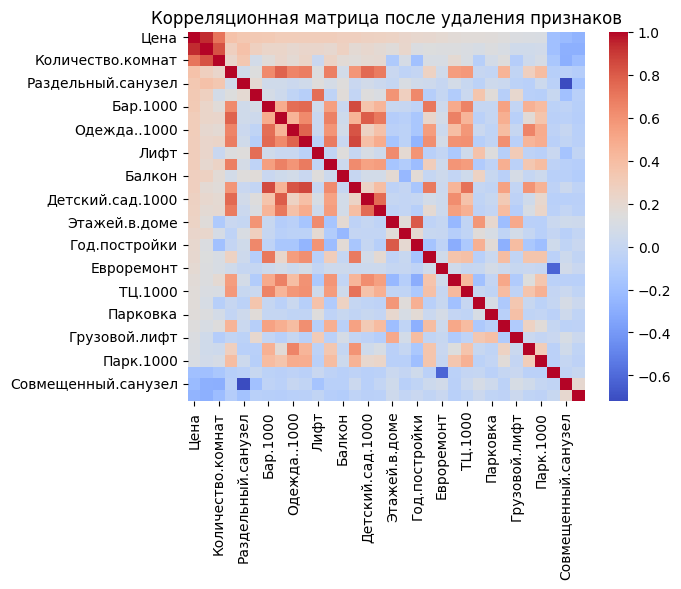


Train data после удаления признаков:
         Цена  Общая.площадь  Количество.комнат  Стоматология.1000  \
0  2350000.0           46.0                  2                  7   
1  1799000.0           44.6                  2                  5   
2  2800000.0           53.0                  2                  8   
3  3970000.0           64.0                  2                 15   
4  1880000.0           33.3                  1                  2   

   Раздельный.санузел  Мусоропровод  Бар.1000  Аптека.1000  Одежда..1000  \
0                   0             0         2           18             2   
1                   0             0         1           11             3   
2                   0             1         3           15             4   
3                   0             0        28           17            31   
4                   0             1         0            6             1   

   Банк.1000  ...  ТЦ.1000  Этаж  Парковка  Поликлиника.1000  Грузовой.лифт  \
0         

In [25]:
co_mtx = train_data_price.corr(numeric_only=True)

target_corr = co_mtx["Цена"].sort_values(ascending=False)
print("Корреляция с зависимой переменной (Цена):\n", target_corr)

selected_features = target_corr[target_corr.abs() > 0.1].index
print("\nОтобранные признаки по корреляции с зависимой переменной:\n", selected_features)

train_filtered = train_data_price[selected_features]

co_mtx_filtered = train_filtered.corr()

high_corr_features = set()
for col in co_mtx_filtered.columns:
    for row in co_mtx_filtered.index:
        if co_mtx_filtered.loc[row, col] > 0.95 and row != col:
            high_corr_features.add(col)

high_corr_features = high_corr_features - {'Цена'}
train_filtered = train_filtered.drop(columns=high_corr_features)

selected_features_test = [col for col in selected_features if col != 'Цена']
test_filtered = test_data_price[selected_features_test]
test_filtered = test_filtered.drop(columns=high_corr_features)

co_mtx_final = train_filtered.corr()
sns.heatmap(co_mtx_final, cmap="coolwarm")
plt.title('Корреляционная матрица после удаления признаков')
plt.show()

print("\nTrain data после удаления признаков:\n", train_filtered.head())
print("\nTest data после удаления признаков:\n", test_filtered.head())


 # Построим дерево решений. Визуализировать результат.

## 1. Titanic — классификация

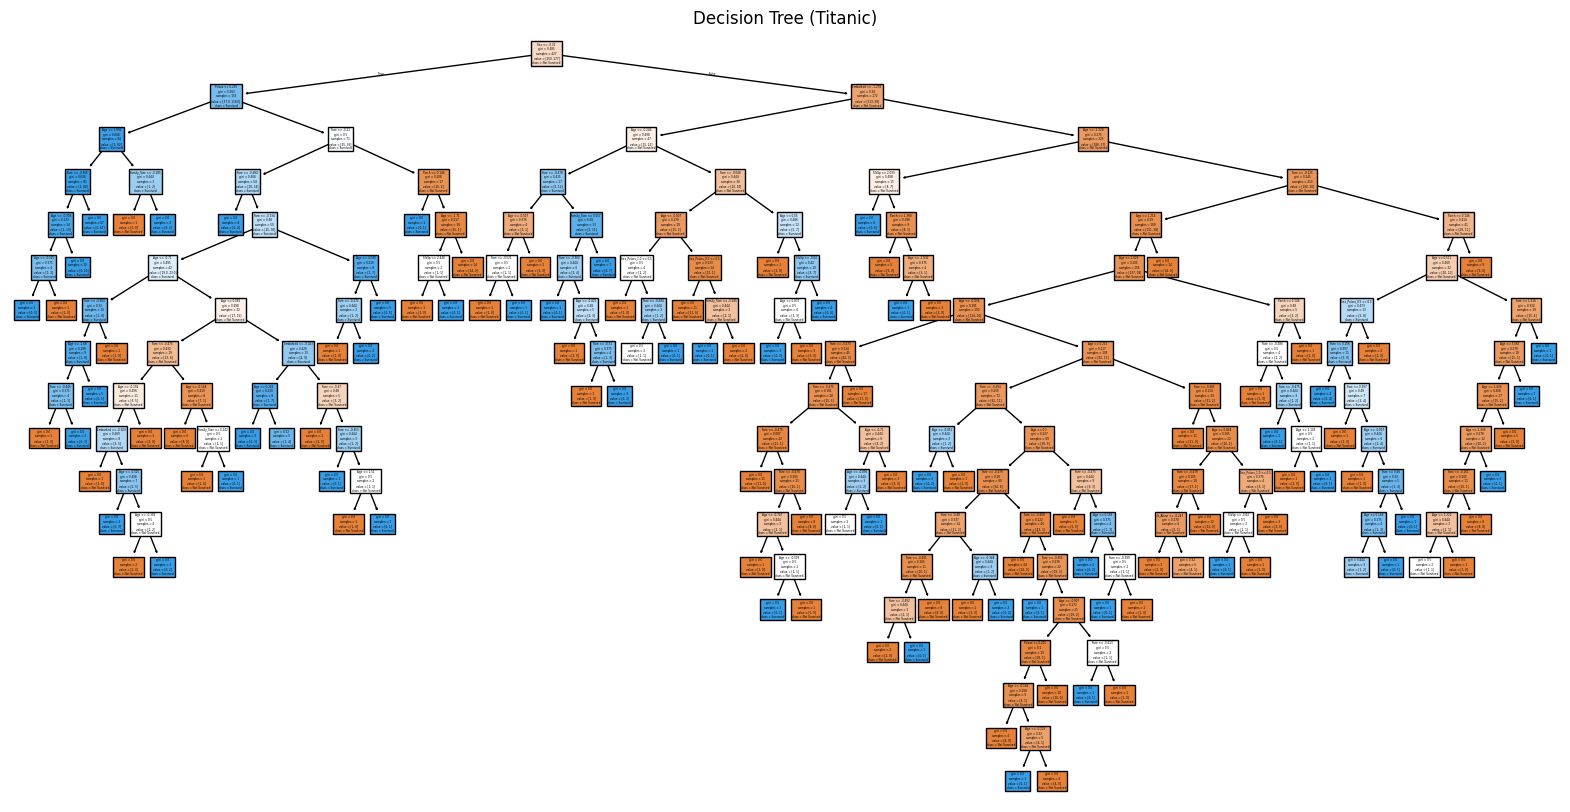

=== Titanic: Базовая модель ===
Accuracy: 0.8317757009345794
F1-score: 0.7272727272727273
Лучшие параметры: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
F1-score при лучших параметрах (кроссвалидация): 0.728396132646607
=== Titanic: Обрезанное дерево ===
Accuracy: 0.7663551401869159
F1-score: 0.6031746031746031
Titanic: сохранено в predicted_titanic.csv
   PassengerId  Survived
0          384         1
1          882         0
2          276         1
3          648         0
4          224         0


In [26]:
X_titanic = train_data_titanic.drop(columns='Survived')
y_titanic = train_data_titanic['Survived']
X_train_titanic, X_val_titanic, y_train_titanic, y_val_titanic = train_test_split(
    X_titanic, y_titanic, test_size=0.2, random_state=42
)

clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train_titanic, y_train_titanic)

plt.figure(figsize=(20, 10))
plot_tree(clf, filled=True, feature_names=X_train_titanic.columns, class_names=["Not Survived", "Survived"])
plt.title("Decision Tree (Titanic)")
plt.show()

y_val_pred = clf.predict(X_val_titanic)
print("=== Titanic: Базовая модель ===")
print("Accuracy:", accuracy_score(y_val_titanic, y_val_pred))
print("F1-score:", f1_score(y_val_titanic, y_val_pred))

param_grid_clf = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_clf = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_clf, cv=5, scoring='f1')
grid_clf.fit(X_train_titanic, y_train_titanic)

results_clf = pd.DataFrame(grid_clf.cv_results_)

print("Лучшие параметры:", grid_clf.best_params_)
print("F1-score при лучших параметрах (кроссвалидация):", grid_clf.best_score_)

best_clf = DecisionTreeClassifier(random_state=42, **grid_clf.best_params_)
best_clf.fit(X_train_titanic, y_train_titanic)
y_val_pruned = best_clf.predict(X_val_titanic)

print("=== Titanic: Обрезанное дерево ===")
print("Accuracy:", accuracy_score(y_val_titanic, y_val_pruned))
print("F1-score:", f1_score(y_val_titanic, y_val_pruned))

best_clf.fit(X_titanic, y_titanic)
final_preds_titanic = best_clf.predict(test_data_titanic)

submission_titanic = pd.DataFrame({
    'PassengerId': test_ids_titanic,
    'Survived': final_preds_titanic
})
submission_titanic.to_csv("predicted_titanic.csv", index=False)
print("Titanic: сохранено в predicted_titanic.csv")
print(submission_titanic.head())

## 2. Price — регрессия

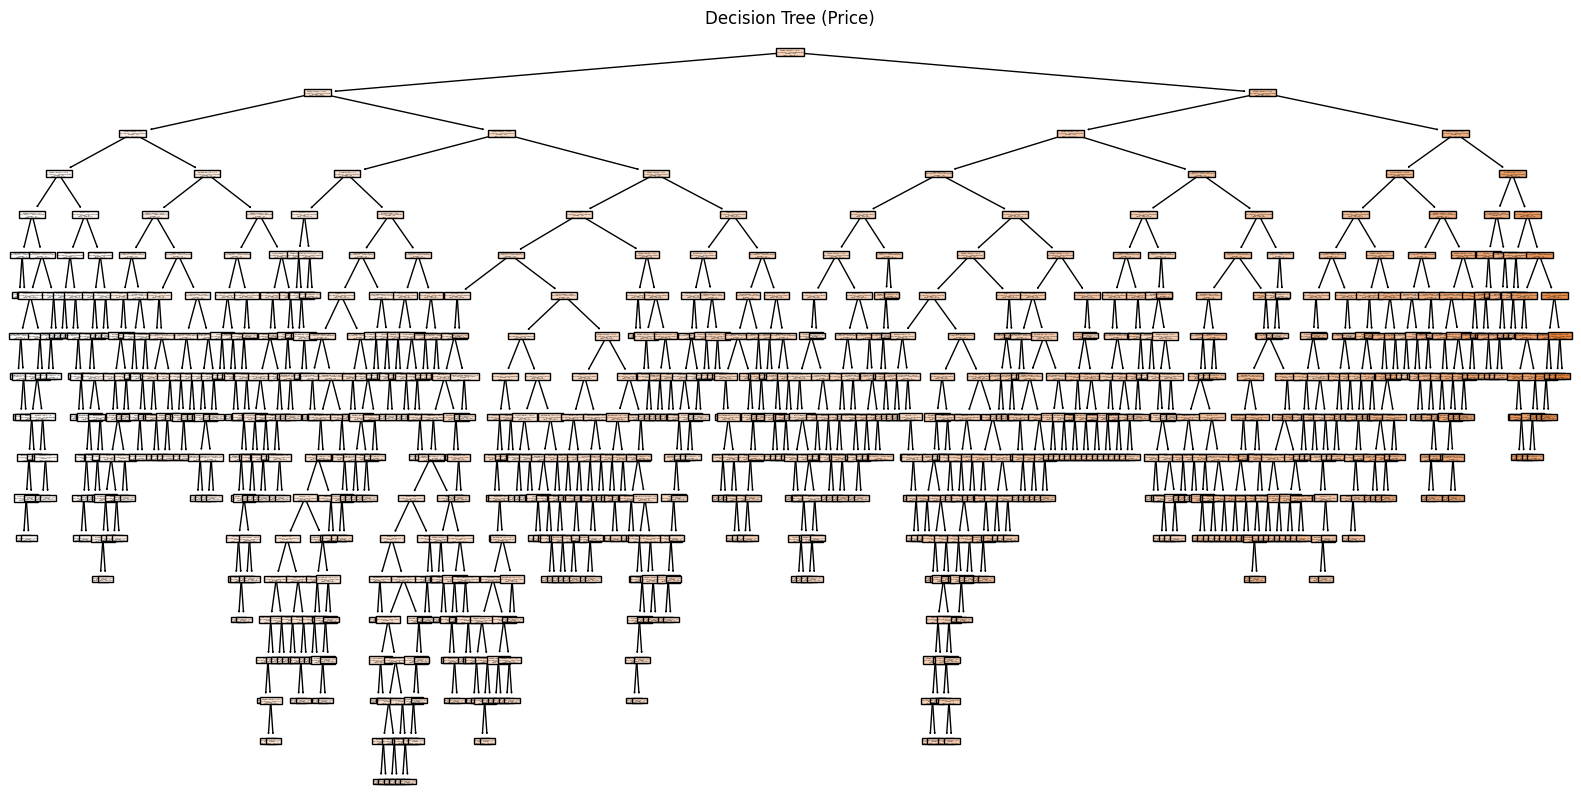

=== Price: Базовая модель ===
RMSE: 419729.67490993533
R²: 0.8470379750873431
Лучшие параметры: {'max_depth': 7, 'min_samples_split': 10}
RMSE при лучших параметрах (кроссвалидация): 376339.8944156027
=== Price: Обрезанное дерево ===
RMSE: 0.0
R²: 0.8610751839771404
Price: сохранено в predicted_price.csv
     id          Цена
0   747  2.100000e+06
1   962  1.535000e+06
2  1105  2.281000e+06
3   795  4.265556e+06
4   390  2.410000e+06


In [27]:
X_price = train_data_price.drop(columns='Цена')
y_price = train_data_price['Цена']
X_train_price, X_val_price, y_train_price, y_val_price = train_test_split(
    X_price, y_price, test_size=0.2, random_state=42
)

reg = DecisionTreeRegressor(random_state=42)
reg.fit(X_train_price, y_train_price)

plt.figure(figsize=(20, 10))
plot_tree(reg, filled=True, feature_names=X_train_price.columns)
plt.title("Decision Tree (Price)")
plt.show()

y_val_pred_price = reg.predict(X_val_price)
print("=== Price: Базовая модель ===")
rmse = np.sqrt(mean_squared_error(y_val_price, y_val_pred_price))
print("RMSE:", rmse)
print("R²:", r2_score(y_val_price, y_val_pred_price))

param_grid_reg = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10]
}
grid_reg = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid_reg, cv=5, scoring='neg_root_mean_squared_error')
grid_reg.fit(X_train_price, y_train_price)

results_reg = pd.DataFrame(grid_reg.cv_results_)

print("Лучшие параметры:", grid_reg.best_params_)
print("RMSE при лучших параметрах (кроссвалидация):", -grid_reg.best_score_)

best_reg = DecisionTreeRegressor(random_state=42, **grid_reg.best_params_)
best_reg.fit(X_train_price, y_train_price)
y_val_pruned_price = best_reg.predict(X_val_price)

print("=== Price: Обрезанное дерево ===")
rmse = np.sqrt(mean_squared_error(y_val_pruned_price, y_val_pruned_price))
print("RMSE:", rmse)
print("R²:", r2_score(y_val_price, y_val_pruned_price))

best_reg.fit(X_price, y_price)
final_preds_price = best_reg.predict(test_data_price)

submission_price = pd.DataFrame({
    'id': test_ids_price,
    'Цена': final_preds_price
})
submission_price.to_csv("predicted_price.csv", index=False, encoding='utf-8')
print("Price: сохранено в predicted_price.csv")
print(submission_price.head())